In [1]:
'''
# For GPU support, install the following packages:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip install gymnasium[box2d]
!pip install stable-baselines3[extra]
!pip install ipywidgets
'''

'\n# For GPU support, install the following packages:\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128\n!pip install gymnasium[box2d]\n!pip install stable-baselines3[extra]\n!pip install ipywidgets\n'

In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import gymnasium as gym
import itertools
import time
import os


# Import Frame Stacker Wrapper and Grayscale Wrapper
from gymnasium.wrappers import GrayscaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import matplotlib
import matplotlib.pyplot as plt
# Import PPO
from stable_baselines3 import PPO

In [3]:
# check if GPU is available
torch.cuda.is_available()

True

# Using an image as a state

In [4]:
class ImageObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        sample_img = env.render()
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=sample_img.shape,
            dtype=sample_img.dtype
        )

    def observation(self, obs):
        # Return the rendered image as the observation
        return self.env.render()

# Create the LunarLanderContinuous environment
env = gym.make("LunarLanderContinuous-v3", render_mode="rgb_array")

# Reset the environment to get the first state
state, _ = env.reset()

env = ImageObservationWrapper(env)
state, _ = env.reset()

print(state.shape)  # Should be (height, width, 3)

(400, 600, 3)


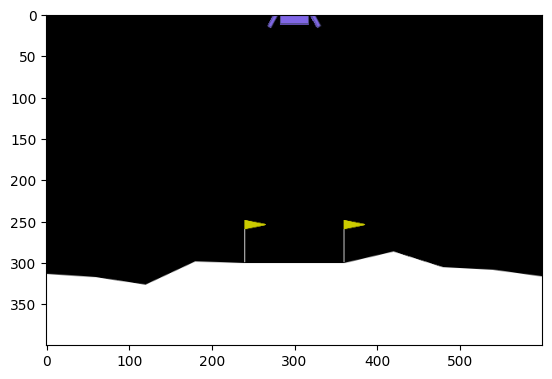

In [5]:
plt.imshow(state)

# Converting the image to grayscale and stacking frames

In [6]:
# Grayscale
env = GrayscaleObservation(env, keep_dim=True)

# Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])

# Stack the frames
env = VecFrameStack(env, n_stack=4, channels_order='last')  # Stack 4 frames

state = env.reset()

state.shape # Should be (1, height, width, 4) for 4 stacked frames

(1, 400, 600, 4)

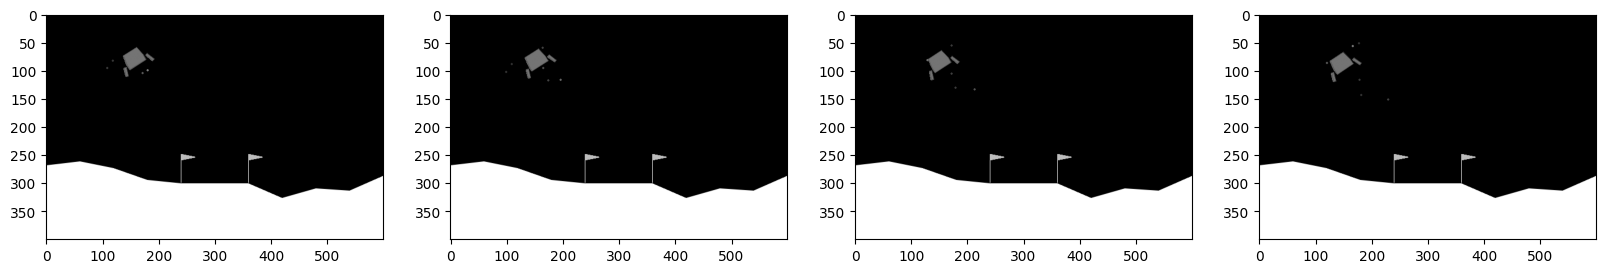

In [13]:
state = env.reset()

for i in range(60):
    state, reward, done, info = env.step([env.action_space.sample()])

# Visualize stacked frames
plt.figure(figsize=(20, 16))
for idx in range(state.shape[3]):

    plt.subplot(1, 4, idx + 1)
    plt.imshow(state[0, :, :, idx], cmap='gray')
plt.show()

> stacked images

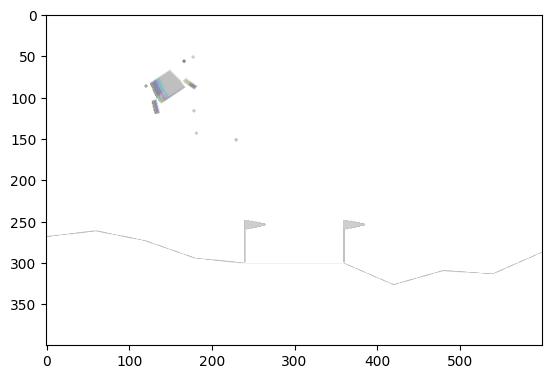

In [14]:
plt.imshow(state[0])

In [15]:
state = env.reset()

# Train the RL agent using PPO

In [16]:
agent = PPO(
    "CnnPolicy",
    env,
    learning_rate=1e-4,
    n_steps=512,
    batch_size=64,
    device="cuda",
    tensorboard_log="./ppo_lunarlander_tensorboard/"
)

In [17]:
# Check if CUDA is available
print(torch.cuda.is_available())  # Should print True if GPU is available

# Check the device of the policy network
print(agent.policy.device)  # Should print 'cuda:0' if using GPU

True
cuda:0


In [18]:
# Train the agent and see statistics in the output
agent.learn(total_timesteps=1_000_000, tb_log_name="run1")

# Save the trained agent
agent.save("ppo_lunarlander_continuous")

# Test

In [32]:
# Create a separate environment for rendering
render_env = gym.make("LunarLanderContinuous-v3", render_mode="human")
state_render, _ = render_env.reset()

# Reset the wrapped environment for agent
state_agent = env.reset()

done = False
while not done:
    # Get action from agent using stacked grayscale state
    action, _ = agent.predict(state_agent, deterministic=True)
    # Step in the agent's environment
    state_agent, reward, done, info = env.step(action)
    # Step in the render environment with the same action
    state_render, reward_render, done_render, _, _ = render_env.step(action[0])
    render_env.render()
    time.sleep(0.03)  # Slow down for visualization

render_env.close()

In [37]:
# Reset the environment
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action, _ = agent.predict(state, deterministic=True)
    state, reward, done, info = env.step(action)
    total_reward += reward

print(f"Total reward for this episode: {total_reward}")

Total reward for this episode: [-397.85266]
